# Project 2: Random Forests and Ensembles
## AI Project 2 2023
### COMP-3703 (241551) Introduction to Artificial Intelligence
Santiago Pinto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tabulate import tabulate


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## 1.1/1.2

In [2]:
# Allows pandas to show all columns
pd.set_option('display.max_columns', None)

In [3]:
# Importing data
imgatt = pd.read_csv('G:/RRC v2/Semester 3/RRC_Projects_Santiago/Comp-3703/Assignments/Assignment 2/CUB_200_2011/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt',
                              sep='\s+', names = ['imgid','attid','present']
                              , usecols=[0, 1, 2], on_bad_lines='skip')

imgatt.head()

,imgid,attid,present
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,1


In [4]:
# Printing out general info on dataset
print(f'{imgatt.info()}')

# Printing out some more general info
print(f'\n{imgatt.describe()}')

# Printing out null and nan count
print(f'\nThere are {imgatt.isnull().sum().sum()} null values')

# Prining out total duplicated valus and shape of data
print(f'\nShape of data {imgatt.shape}\nThere are {imgatt.duplicated().sum()} duplicated values')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677856 entries, 0 to 3677855
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   imgid    int64
 1   attid    int64
 2   present  int64
dtypes: int64(3)
memory usage: 84.2 MB
None

              imgid         attid       present
count  3.677856e+06  3.677856e+06  3.677856e+06
mean   5.894500e+03  1.565000e+02  1.008868e-01
std    3.402903e+03  9.006619e+01  3.011788e-01
min    1.000000e+00  1.000000e+00  0.000000e+00
25%    2.947750e+03  7.875000e+01  0.000000e+00
50%    5.894500e+03  1.565000e+02  0.000000e+00
75%    8.841250e+03  2.342500e+02  0.000000e+00
max    1.178800e+04  3.120000e+02  1.000000e+00

There are 0 null values

Shape of data (3677856, 3)
There are 0 duplicated values


In [5]:
# Importing labels
imglabels = pd.read_csv("G:\RRC v2\Semester 3\RRC_Projects_Santiago\Comp-3703\Assignments\Assignment 2\CUB_200_2011\CUB_200_2011\CUB_200_2011\image_class_labels.txt",
                              sep='\s+', names = ['labels'],usecols=[1], on_bad_lines='skip')
# Displaing first 5 labels
imglabels.head()

,labels
0,1
1,1
2,1
3,1
4,1


In [6]:
# Printing out general info
print(f'{imglabels.info()}')

# Printing out more general info
print(f'\n{imglabels.describe()}')

# Printing out null and nan count
print(f'\nThere are {imglabels.isnull().sum().sum()} null values')

# Printing out shape of data and total duplicate values
print(f'\nShape of data {imglabels.shape}\nThere are {imglabels.duplicated().sum()} duplicated values')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  11788 non-null  int64
dtypes: int64(1)
memory usage: 92.2 KB
None

             labels
count  11788.000000
mean     101.126315
std       57.476826
min        1.000000
25%       51.000000
50%      101.000000
75%      151.000000
max      200.000000

There are 0 null values

Shape of data (11788, 1)
There are 11588 duplicated values


There are no nan values or duplicated values in imgatt

There are no null values but there are 11588 dublicated values in imglabels

The shape for imgatt is (3677856, 3)

The shape for imglabels is (11788, 1)

imglabels seems to contain less rows than imgatt for some reason, this may cause issues later down the line in the model creation. If there are no labels for certain points.

## 1.3 Data Transformation

In [7]:
# Pivoting the data and setting imgid to index
imgatt2 = imgatt.pivot(index = 'imgid', columns='attid', values = 'present')

# Printing out shape
imgatt2.shape

(11788, 312)

In [8]:
# Displaying pivoted data
imgatt2

attid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
imgid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,

## 1.4 Data Merging and Shuffle 

In [9]:
# setting both indexes to be the same
imglabels.index = imgatt2.index

In [10]:
# Merging labels and features
new_df = pd.merge(imgatt2, imglabels, left_index=True, right_index=True)

# Shuffling data
new_df = new_df.sample(frac=1, random_state=10)

In [11]:
new_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,labels
imgid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8281,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,141
7766,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,133
4970,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,86
4515,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,78
424

In [12]:
# Splitting into labels and features
attributes = new_df.iloc[0:11788 , 0:312]
labels = new_df.iloc[0:11788 , 312:313]

In [13]:
# Setting labels and features to numpy arrays
labels = np.array(labels).flatten()
attributes = np.array(attributes)

## 2.0 Training and Testing Sets

In [14]:
# Creating train test split
x_train, x_test, y_train, y_test = train_test_split(attributes, labels
                                       , test_size=0.3, random_state=42)

In [15]:
# Creating function to print out accuracy on training and testing dataset
def score(model):
    # Evaluating accuracy on model
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)

    # Printing out accuracy
    print('Accuracy of training set: ' + str(train_acc) + '\n'
        + 'Accuracy of testing set: ' + str(test_acc))

## 3.0 Random Forest Classifier

In [16]:
# Creating random forest Classifier
rfc = RandomForestClassifier(max_features=15, n_estimators=25, random_state=42)

In [17]:
# Fitting RFC 
model_rfc = rfc.fit(x_train, y_train)

In [18]:
score(model_rfc)

Accuracy of training set: 0.9984244334020119
Accuracy of testing set: 0.3853548204693243


The training accuracy is nearly 100%, meanwhile the accuracy on the testing set is under 40%. Since the training accuracy is substantially much higher, it is safe to assume that the model is overfitting the training data and as a result the model is performing poorly.

This may be due to possibly missing labels for some data points as previously mentioned, imglabels was significantly lower than imgatt. Although the rest of the pre processing should have fixed this issue

## 4.0 Confusion Matrix

<Figure size 5000x5000 with 0 Axes>

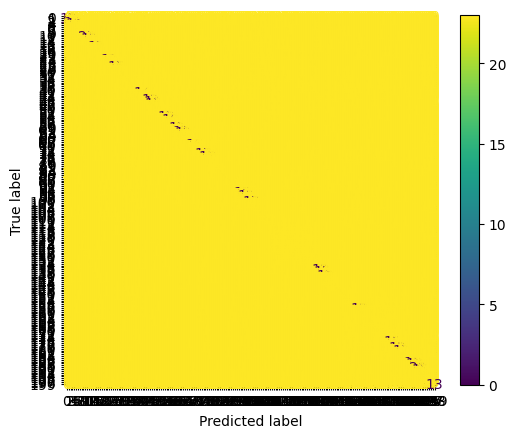

In [19]:
plt.figure(figsize=(50,50))
# Predicting Valiadation data for confusion matrix
predict_rfc = model_rfc.predict(x_test)

# Creating confusion matrix
cm_rfc = confusion_matrix(predict_rfc, y_test)

# Plotting confusion matrix
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)
disp_1.plot()
plt.grid(False)
plt.show()

## 5.0 Model Comparisons

### KNeighborsClassifier

In [20]:
# Creating knn
KNN = KNeighborsClassifier()

In [21]:
# Fitting knn model to training data
model_KNN = KNN.fit(x_train, y_train)

# Printing out knn accuracies
score(model_KNN)

Accuracy of training set: 0.5227245182402133
Accuracy of testing set: 0.31721798134011875


### Decision Tree

In [22]:
# Creating DT
DT = DecisionTreeClassifier()

In [23]:
# Fitting DT to training data 
model_DT = DT.fit(x_train, y_train)

# Printing out DT accuracies
score(model_DT)

Accuracy of training set: 0.9984244334020119
Accuracy of testing set: 0.2598247102063896


### Words

Both the KNN model had a 50% accuracy on the training set, which was more than 40% lower than the Decision tree. However the accuracy on the testing set was higher on KNN than DT (DT was 26%, KNN was 31%).

So over all the KNN model performed much better than the DT model

## 6.0 Cross-Validation

In [24]:
# Created function to print out cv score
def cv_score(model, need_score):

    # Comuputes cv score
    score = cross_val_score(model, x_test, y_test, cv = 5)

    # Getting out accuracy 
    acc_avg = score.mean()

    # Getting standard deviation
    std = score.std()

    if need_score == True:

        # Returning cv_score
        return score
    else:

        # Printing out some words
        print(f'Average accuracy on the testing dataset is {acc_avg}\nStandard Deviation is {std}\n')

In [25]:
print('Random Forest Classifier')
cv_score(model_rfc, False)

print('K Nearest Neighbours')
cv_score(model_KNN, False)

print('Decision Tree Classifier')
cv_score(model_DT, False)

Random Forest Classifier
Average accuracy on the testing dataset is 0.3220203134114864
Standard Deviation is 0.011422491403493216

K Nearest Neighbours
Average accuracy on the testing dataset is 0.25077793493635075
Standard Deviation is 0.008189623342965685

Decision Tree Classifier
Average accuracy on the testing dataset is 0.20073078736445074
Standard Deviation is 0.016119500832950818



## 7.0 Hyperparameter Tuning

In [26]:
# Created according to #7 instructions
max_features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                    110, 120, 130, 140, 160, 170, 180, 190, 200]

# Tracks all scores and values for each iteration
m_feat_track = []
n_est_track = []
cv_score_track = []

# Tracks features and accuracy for tabulation
tab_track = []

# Holds the best parametes given by loop
best_param = []

# Loops through ,ax features
for i in range(len(max_features)):

    # Loops through n estimators to make sure every combination is tested
    for _ in range(len(n_estimators)):

        # Controls what is used for max features based in iteration
        mf = max_features[i]

        # Creates random forest classifier based on loop
        rfc = RandomForestClassifier(max_features=mf,
                                    n_estimators=n_estimators[_], 
                                    random_state=42)   
        
        # Calculate cv_score
        cv__score = cv_score(rfc, True).mean()

        # appends current parameters for graphing later on
        m_feat_track.append(mf) 
        n_est_track.append(n_estimators[_])
        cv_score_track.append(cv__score)

        # Appends all parameters for tabulatuon later
        tab_track.append([mf, n_estimators[_], 
                        cv__score])
        
        # Stores highest cv score
        curr_high = 0

        # Checks if the saved cv_score is lower than the current cv_score
        if curr_high < cv__score:
            curr_high==cv__score
            best_param = [mf, n_estimators[_], 
                        cv__score]
    # prints current iteration loop is on
    print(f'Finished {i}/{len(max_features)}')
print(f'Finished {10}/{len(max_features)}')

Finished 0/10
Finished 1/10
Finished 2/10
Finished 3/10
Finished 4/10
Finished 5/10
Finished 6/10
Finished 7/10
Finished 8/10
Finished 9/10
Finished 10/10


In [27]:
# Column names for tabualtion
col_names = ['max features',
             'n estimators', 
             'Testing accuracy']

# Prints tabulated
print(tabulate(tab_track, headers=col_names))

# Prints the best parameters overall and the accuracy 
print(f'\n\nBest Parameters for Random Forest:\nMax Features: {best_param[0]}, N Estimators:{best_param[1]}. Accuracy was {best_param[2]}')

  max features    n estimators    Testing accuracy
--------------  --------------  ------------------
             5              10            0.206392
             5              20            0.263781
             5              30            0.296294
             5              40            0.315239
             5              50            0.32513
             5              60            0.330223
             5              70            0.340686
             5              80            0.348318
             5              90            0.354819
             5             100            0.361606
             5             110            0.366978
             5             120            0.372067
             5             130            0.373478
             5             140            0.377153
             5             160            0.380541
             5             170            0.376017
             5             180            0.380541
             5             190  

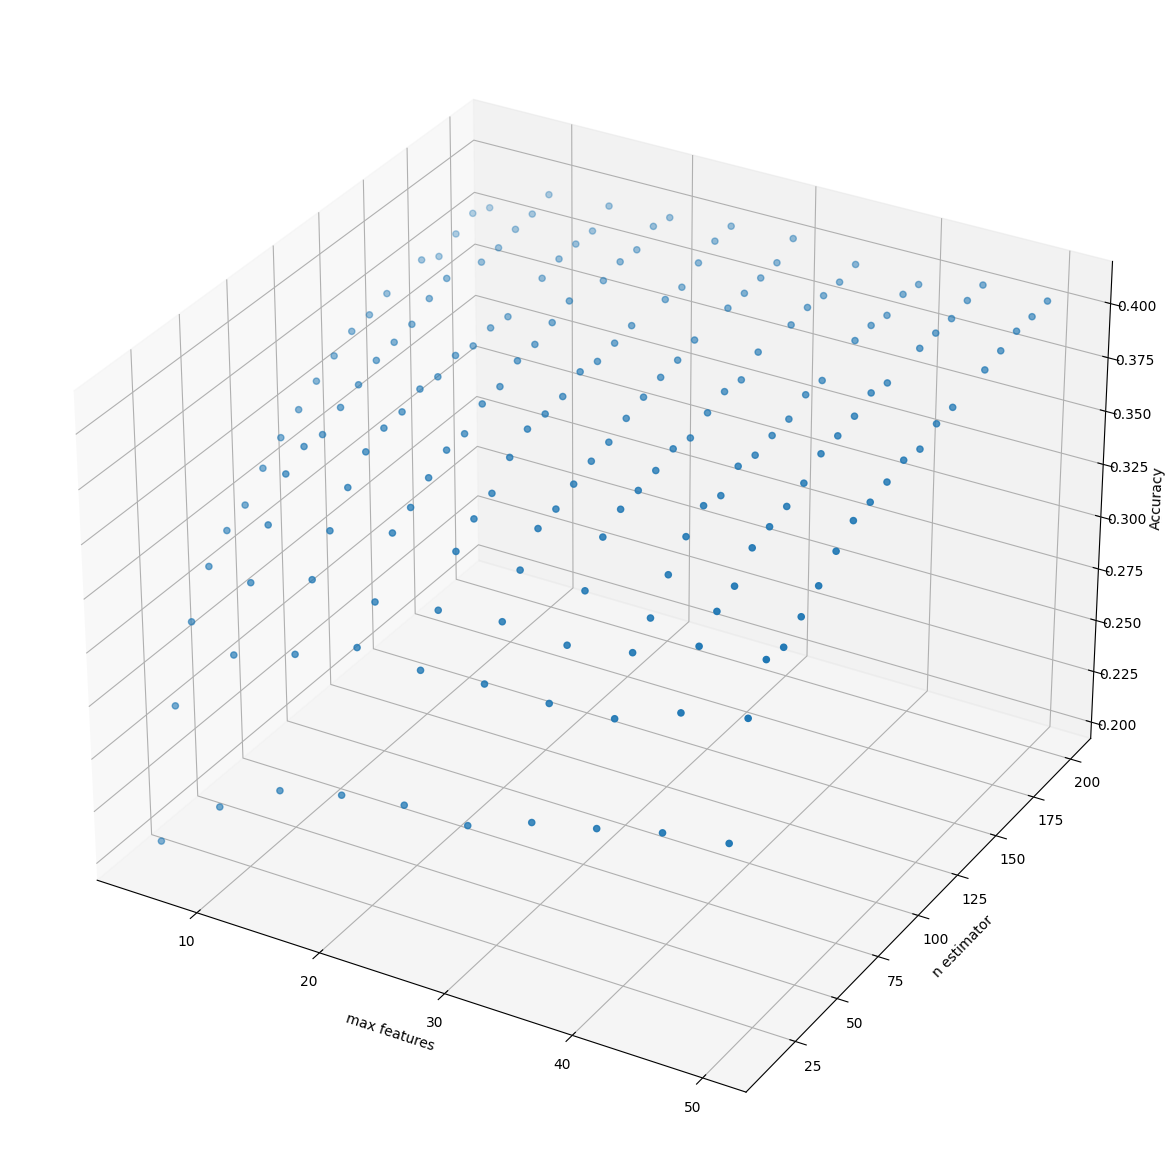

In [28]:
# creates the 3D plot
plot_3d = plt.figure(figsize=(15, 15)).add_subplot(projection='3d')

# Plots the data on 3D plot
plot_3d.scatter(m_feat_track, 
                n_est_track, 
                cv_score_track)

# Sets axis titles
plot_3d.set_xlabel('max features')
plot_3d.set_ylabel('n estimator')
plot_3d.set_zlabel('Accuracy')

# shows plot

plt.show()

In [29]:
# Creating new trained random forest using the best features found by loop above
retrained_rfc = RandomForestClassifier(max_features=50
                                       , n_estimators=200, random_state=42)
# Fitting training data to new RFC
retrained_rfc.fit(x_train, y_train)

# Scoring new model
retrained_rfc_score = retrained_rfc.score(x_test, y_test)

In [30]:
# Printing out new RFC score
retrained_rfc_score

0.45773254170200733

## 8.0 Stacking Ensemble

In [31]:
# Creating stacking ensemble base estimators 
base_est = [('dt', DecisionTreeClassifier(random_state=42)),
              ('knn', KNeighborsClassifier()),
              ('svm', SVC(random_state=42))]

# Creating final estimator
final_est = RandomForestClassifier(random_state=42)

In [32]:
# Creating stacking ensemble
stacking_clf = StackingClassifier(estimators=base_est, final_estimator=final_est)

# Fitting stacking ensemble to training data
stacking_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('svm', SVC(random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [33]:
# Printing out data scores
score(stacking_clf)

Accuracy of training set: 0.9198884983638347
Accuracy of testing set: 0.4475544246536613


The stackig ensemble improved the accuracy of the model on the testing set by a marginally fair amount, but it still does not manage to reach even over 50% accuracy

## 9.0 Improving Perfomance

In [34]:
new_base_est = []

In [35]:
# Grid search parameters
dt_params = {'max_depth': [5, 10, 15, 20, 25, 40, 50],
             'criterion': ['entropy', 'log_loss'],
             'min_samples_split': [2, 4, 6, 8],
             'min_samples_leaf': [2, 4, 6, 8],
             'random_state': [42]}

# Creating DT
dt = DecisionTreeClassifier()

# Grid search in DT
grid_search_dt = GridSearchCV(dt, dt_params)

# fitting grid search model to training data
grid_search_dt.fit(x_train, y_train)

In [ ]:
# Printing out accuracy and parameters
print(f'Accuracy on testing set {grid_search_dt.score(x_test, y_test)}')
print(f'Best parameters found for decision tree \n{grid_search_dt.best_estimator_}')
new_base_est.append(('dt', grid_search_dt.best_estimator_))

Accuracy on testing set 0.2321176137970031
Best parameters found for decision tree 
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=6,
                       random_state=42)


In [ ]:
# Grid search parameters
knn_params = {'n_neighbors': [10, 20, 40],
              'leaf_size': [30, 40, 50],
              'weights': ['distance'],
              'p': [2, 1]
              }

# Creating KNN
knn = KNeighborsClassifier()

# Grid search
grid_search_knn = GridSearchCV(knn, knn_params)

# Fitting gridsearch model to training data
grid_search_knn.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [30, 40, 50], 'n_neighbors': [10, 20, 40],
                         'p': [2, 1], 'weights': ['distance']})

In [ ]:
# Printing out accuracy and parameters
print(f'Accuracy on testing set {grid_search_knn.score(x_test, y_test)}')
print(f'Best parameters found for decision tree \n{grid_search_knn.best_estimator_}')
new_base_est.append(('knn', grid_search_knn.best_estimator_))

Accuracy on testing set 0.34322872490811424
Best parameters found for decision tree 
KNeighborsClassifier(n_neighbors=10, p=1, weights='distance')


In [ ]:
# Creating grid search parameters
svm_params = {'C': [5, 25, 40, 50],
             'kernel' : ['linear', 'rbf'],
             'random_state': [42]}

# Creating SVM
svm = SVC()

# Creating grid search
grid_search_svm = GridSearchCV(svm, svm_params)

# Fitting grid search to training data
grid_search_svm.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 25, 40, 50], 'kernel': ['linear', 'rbf'],
                         'random_state': [42]})

In [ ]:
# Printing out accuracy and parameters
print(f'Accuracy on testing set {grid_search_svm.score(x_test, y_test)}')
print(f'Best parameters found for decision tree \n{grid_search_svm.best_estimator_}')
new_base_est.append(('svm', grid_search_svm.best_estimator_))

Accuracy on testing set 0.4902459711620017
Best parameters found for decision tree 
SVC(C=5, random_state=42)


In [ ]:
# Creating stacking ensemble
stacking_clf = StackingClassifier(estimators=new_base_est, final_estimator=retrained_rfc)
stacking_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       min_samples_leaf=6,
                                                       random_state=42)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=10, p=1,
                                                     weights='distance')),
                               ('svm', SVC(C=5, random_state=42))],
                   final_estimator=RandomForestClassifier(max_features=50,
                                                          n_estimators=200,
                                                          random_state=42))

In [ ]:
score(stacking_clf)

Accuracy of training set: 0.9452187613622591
Accuracy of testing set: 0.47610969748374327


Even after performing a grid search on all classifiers and using the best of each model, the stacking ensemble is unable to get an accuracy in the testing set better than 48%.

I am unsure wether this was due to bad preprocessing or I created the stacking ensemble incorrctly. I attempted many versions of hyper parameters for the stacking ensemble, none of them could pass 48% accuracy